# Derivation of follow-up time required on LSST for GW kilonovae identification

## `jupyter` notebook boilerplate

In [1]:
import datetime
print(datetime.datetime.now())

2018-10-19 10:02:48.893434


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
import os
from collections import namedtuple
from functools import partial
import astropy
import astropy.coordinates
import astropy.units as u
import psycopg2
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import healpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from numpy.polynomial.polynomial import polyfit
from numpy.polynomial.polynomial import Polynomial
from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.basemap import Basemap

mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)

## Extract linear parameters from a published plot of the localization CDF

The information we need is in figure 3 of Chen & Holz (2016) ([arxiv:1612.01471](https://arxiv.org/abs/1612.01471)). The lines are roughly linear in the regime in which we are interested. So, I take a screen capture, and fit lines to values read from the plot.

Read the screen captured image:

(636, 948, 4)


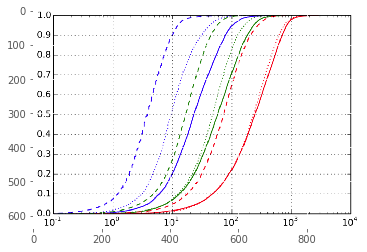

In [3]:
im = mpl.image.imread('GWLocalizationArea.png')
print(im.shape)
plt.imshow(im)

Extract the tick marks from the `x` axis, and derive the scale mapping pixels to log(area):

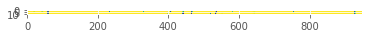

In [4]:
im2 = im[:, :, 0].copy()
plt.imshow(im2[310:320, :])

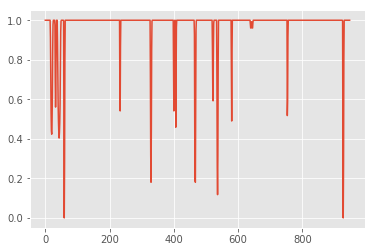

In [5]:
plt.plot(im2[312,:])

In [6]:
np.where(im2[312,:] < 0.6)

(array([ 18,  19,  20,  21,  32,  40,  41,  42,  43,  44,  45,  46,  58,
         59,  60, 233, 328, 329, 330, 400, 401, 406, 465, 466, 467, 522,
        535, 536, 537, 580, 753, 754, 926, 927, 928]),)

Create functions to do the conversion:

In [7]:
pix_to_logarea = Polynomial(polyfit([754.0, 233.0], [3.0, 0.0], 1))
assert abs(pix_to_logarea(233) ) < 0.00001
assert abs(pix_to_logarea(754) - 3) < 0.00001

In [8]:
def pix_to_area(pix):
    logarea = pix_to_logarea(pix)
    area = 10**logarea
    return area

assert abs(pix_to_area(233) - 1) < 0.00001
assert abs(pix_to_area(754) - 1000) < 0.00001

Extract the tick marks from the `y` axis, and derive the scale mapping pixels to the CDF:

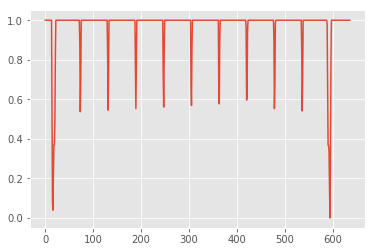

In [9]:
plt.plot(im2[:,806])

In [10]:
np.where(im2[:,806] < 0.8)

(array([ 14,  15,  16,  17,  18,  19,  20,  73,  74, 131, 132, 188, 189,
        190, 246, 247, 304, 305, 362, 363, 420, 421, 478, 479, 536, 537,
        589, 590, 591, 592, 593, 594, 595]),)

Create a function to do the conversion:

In [11]:
pix_to_cdf = Polynomial(polyfit([73.0, 536.0], [0.9, 0.1], 1))
assert abs(pix_to_cdf(73) - 0.9) < 0.00001
assert abs(pix_to_cdf(536) - 0.1) < 0.00001

### Extract the line for the linear region of the O3 HLV CDF

Extract one point from the O3 HLV CDF:

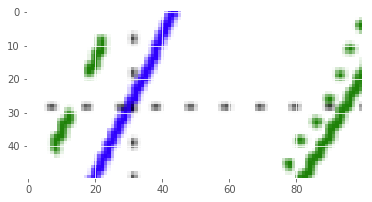

In [12]:
col_min, col_max = 375, 475
row_min, row_max = 450, 500
plt.imshow(im[row_min:row_max, col_min:col_max])

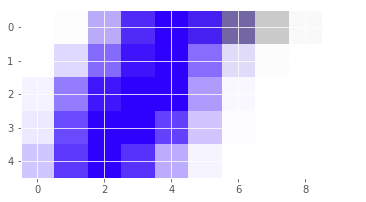

In [13]:
col_min, col_max = 400, 410
row_min, row_max = 480, 485
plt.imshow(im[row_min:row_max, col_min:col_max])

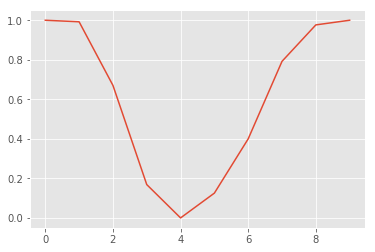

In [14]:
cdf_pix = row_min
plt.plot(im[row_min,col_min:col_max, 1])

In [15]:
area_pix = np.average(np.arange(col_min, col_max), weights=1-im[cdf_pix,col_min:col_max, 1])
cdf_pix, area_pix

(480, 404.3299595246335)

In [16]:
logarea1 = pix_to_logarea(area_pix)
cdf1 = pix_to_cdf(cdf_pix)
print(logarea1, cdf1, 10**logarea1)

0.9865448725026897 0.19676025917926565 9.694934348588747


Extract a second point from the O3 HLV CDF:

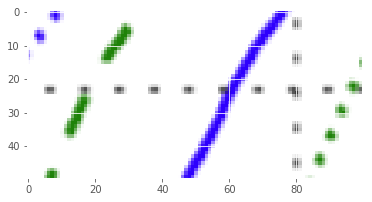

In [17]:
col_min, col_max = 500, 600
row_min, row_max = 50, 100
plt.imshow(im[row_min:row_max, col_min:col_max])

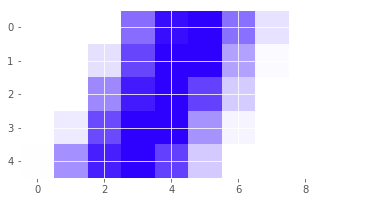

In [18]:
col_min, col_max = 553, 563
row_min, row_max = 80, 85
plt.imshow(im[row_min:row_max, col_min:col_max])

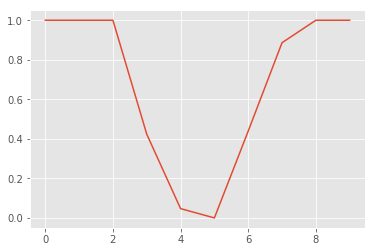

In [19]:
cdf_pix = row_min+1
plt.plot(im[row_min,col_min:col_max, 1])

In [20]:
area_pix = np.average(np.arange(col_min, col_max), weights=1-im[cdf_pix,col_min:col_max, 1])
cdf_pix, area_pix

(81, 557.2542372971801)

In [21]:
logarea2 = pix_to_logarea(area_pix)
cdf2 = pix_to_cdf(cdf_pix)
print(logarea2, cdf2, 10**logarea2)

1.867106932613323 0.8861771058315333 73.63883897855531


In [22]:
hlv_logarea_to_cdf = Polynomial(polyfit([logarea1, logarea2], [cdf1, cdf2], 1))
hlv_cdf_to_logarea = Polynomial(polyfit([cdf1, cdf2], [logarea1, logarea2], 1))

In [23]:
10**hlv_cdf_to_logarea(0.5)

23.65155850596115

Good, that matches the value listed in table 2 of the paper (row 1, column 3).

# Events per 90% area

## Estimate the total number of events that can be followed up. 

Calculate the number of GW events:

In [24]:
astrophysical_rate = 1500 * 1/(u.Gpc**3 * u.year)
sensitivity_volume = 0.03 * (u.Gpc**3)
survey_duration = 10 * u.year
gw_detector_uptime = 0.8 ;# total guess
num_gw_events = astrophysical_rate * sensitivity_volume * survey_duration * gw_detector_uptime
print(num_gw_events)

360.0


Some of these events will be too far north, or too close to the sun. Exclude them:

In [25]:
def cap_fraction_sphere(angle):
    area_spherical_cap = 2*np.pi * (1-np.cos(angle))
    area_sphere = 4*np.pi
    fraction_sphere = area_spherical_cap / area_sphere
    return fraction_sphere

What fraction are too far north?

In [26]:
max_dec = 30 * u.deg
frac_too_far_north = cap_fraction_sphere(90*u.deg - max_dec)
frac_too_far_north

<Quantity 0.25>

What fraction are too low in the sky when the sun is down?

In [27]:
max_airmass = 3.0
max_zd = np.arccos(1/max_airmass) * u.radian
min_alt = 90 * u.deg - max_zd
twilight_sun_alt = -18 * u.deg
sun_avoidance_radius = min_alt - twilight_sun_alt
frac_near_sun = cap_fraction_sphere(sun_avoidance_radius)
frac_near_sun

<Quantity 0.10317049>

This is really a lower limit, because not all events will be at the same azimuth as the sun.

What fraction are too close to the moon?

In [28]:
moon_avoidance_radius = 20 * u.deg
cap_fraction_sphere(moon_avoidance_radius)

<Quantity 0.03015369>

Let's ignore this -- it's small, and the astrophysical rate isn't precise enough to warrant corrections of this size. It's also complicated -- some fraction of this 3% will overlap area also near the sun.

In [29]:
num_followable_events = num_gw_events * (1 - frac_too_far_north - frac_near_sun)
num_followable_events

<Quantity 232.85862321>

Generate a table (stored as a `pandas.DataFrame`) of different areas of events.

In [30]:
events = pd.DataFrame({'pointings': np.arange(1,9), 'area': np.arange(1,9)*7.8})
events = events.append(pd.DataFrame({'pointings': [13], 'area': 13*7.8}))
events['log_area'] = np.log10(events.area)
events['cdf'] = hlv_logarea_to_cdf(events.log_area)
events.loc[events.pointings ==13, 'cdf'] = 0.95
events

,area,pointings,log_area,cdf
0,7.8,1,0.892095,0.122812
1,15.6,2,1.193125,0.358497
2,23.4,3,1.369216,0.496364
3,31.2,4,1.494155,0.594182
4,39.0,5,1.591065,0.670056
5,46.8,6,1.670246,0.732049
6,54.6,7,1.737193,0.784464
7,62.4,8,1.795185,0.829867
0,101.4,13,2.006038,0.950000


Go from the CDF (given in the plots) to fraction by area bin:

In [31]:
events['cdf_diff'] = events.cdf.rolling(window=2).apply(lambda cdf: cdf[1] - cdf[0])
events.cdf_diff.fillna(events.cdf.iloc[0], inplace=True)

Set a minimum number of pointings per event. Even if the localization area is small, it may be the wrong shape to be covered by the camera footprint. Guess the 4 pointings will be enough to cover even long, skinny (but small in area) localizations.

In [32]:
min_pointings = 4

Put it all together to get a number of pointings per set of events of a given localization area:

In [33]:
events['total_events_followed'] = num_followable_events.value*events.cdf
events['pointings'] = np.maximum(min_pointings, events.pointings)
events['all_event_pointings'] = events.pointings*events.cdf_diff*num_followable_events
events

,area,pointings,log_area,cdf,cdf_diff,total_events_followed,all_event_pointings
0,7.8,4,0.892095,0.122812,0.122812,28.597945,114.391782
1,15.6,4,1.193125,0.358497,0.235685,83.479199,219.525013
2,23.4,4,1.369216,0.496364,0.137867,115.582674,128.413900
3,31.2,4,1.494155,0.594182,0.097818,138.360452,91.111112
4,39.0,5,1.591065,0.670056,0.075874,156.028269,88.339086
5,46.8,6,1.670246,0.732049,0.061993,170.463927,86.613947
6,54.6,7,1.737193,0.784464,0.052415,182.669102,85.436223
7,62.4,8,1.795185,0.829867,0.045404,193.241705,84.580826
0,101.4,13,2.006038,0.950000,0.120133,221.215692,363.661831


From the summary statistics page, a visit is 34 seconds, plus slew time. Minimum slew time is 3 seconds (see lsst doc 28382). Pull a guess out of my hat that slews too and from the localization region will total 60 seconds an average. Filter change operations take 2 minutes (see lsst doc 28382 again), and these are required for color-based followup. 

So, for each of the two rising light curve passes, the time taken will be:

In [34]:
def rising_followup_time(npointings,
                         slew_time_to_region=30,
                         slew_time_from_region=30,
                         slew_time_between_visits=3,
                         time_per_visit=34):
    time_per_pass = (slew_time_to_region 
                     + npointings*time_per_visit
                     + slew_time_between_visits*(npointings - 1)
                     + slew_time_from_region)
    num_passes = 2
    total_time = num_passes * time_per_pass
    return total_time

In [35]:
def color_followup_time(npointings,
                        filter_change_time=60,
                        slew_time_to_region=30,
                        slew_time_from_region=30,
                        slew_time_between_visits=3,
                        time_per_visit=34):
    time_per_pass = (slew_time_to_region 
                     + npointings*time_per_visit
                     + slew_time_between_visits*(npointings - 1)
                     + slew_time_from_region)
    num_passes = 4
    total_time = num_passes * time_per_pass + 2 * filter_change_time
    return total_time

In [36]:
events['time_for_one_rising_followup'] = events.pointings.apply(rising_followup_time)
events['time_for_one_color_followup'] = events.pointings.apply(color_followup_time)
events['all_color_followup_hours'] = (events.cdf_diff*num_followable_events*events.time_for_one_color_followup).cumsum()/3600
events

,area,pointings,log_area,cdf,cdf_diff,total_events_followed,all_event_pointings,time_for_one_rising_followup,time_for_one_color_followup,all_color_followup_hours
0,7.8,4,0.892095,0.122812,0.122812,28.597945,114.391782,410,940,7.467241
1,15.6,4,1.193125,0.358497,0.235685,83.479199,219.525013,410,940,21.797346
2,23.4,4,1.369216,0.496364,0.137867,115.582674,128.413900,410,940,30.179920
3,31.2,4,1.494155,0.594182,0.097818,138.360452,91.111112,410,940,36.127451
4,39.0,5,1.591065,0.670056,0.075874,156.028269,88.339086,484,1088,41.467058
5,46.8,6,1.670246,0.732049,0.061993,170.463927,86.613947,558,1236,46.423301
6,54.6,7,1.737193,0.784464,0.052415,182.669102,85.436223,632,1384,51.115512
7,62.4,8,1.795185,0.829867,0.045404,193.241705,84.580826,706,1532,55.614743
0,101.4,13,2.006038,0.950000,0.120133,221.215692,363.661831,1076,2272,73.269437


Assuming a worst-case scenario, where we only use color-based follow up, plot the numbers of events followed up as a function of time spent:

Text(0,0.5,'Events followed up')

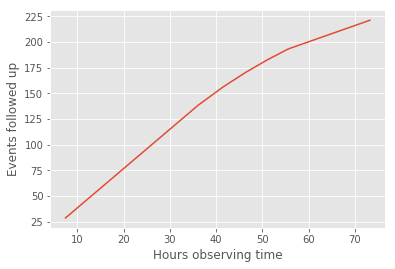

In [37]:
fig, axes = plt.subplots()
events.plot('all_color_followup_hours', 'total_events_followed', legend=False, ax=axes)
axes.set_xlabel("Hours observing time")
axes.set_ylabel("Events followed up")